In [1]:
import shutil

from core.gain import *
from core.rnn_predic import *
from core.models import *
from core.util import *
#from core.window import WindowGenerator, MissData, make_dataset_water, WaterDataGenerator
from core.window import WindowGenerator, make_dataset_gain, make_dataset_water
from core.file_open import make_dataframe
from core.miss_data import MissData
import json

import os

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"


In [3]:
data_path = 'data/'
parameters_dir = 'input'

parameters_file = 'input.json'
parameters_path = '{dir}/{file}'.format(dir=parameters_dir, file=parameters_file)

with open(parameters_path, encoding='utf8') as json_file:
    parameters = json.load(json_file)

gain_parameters = parameters['gain']
rnn_parameters = parameters['rnn']
file_parameters = parameters['file']

In [4]:
parameters_path = parameters_dir+'/'+ file_parameters['watershed'] + '.json'
with open(parameters_path, encoding='utf8') as json_file:
    parameters = json.load(json_file)

In [5]:
pd.set_option('display.max_columns', 1000)

In [6]:
data_parameters = parameters['data']

interpolation_option = data_parameters['interpolation']
colum_idx = data_parameters['columns']
watershed = data_parameters['watershed']
file_names = data_parameters['files']
folder = data_parameters['directorys']
for i in range(len(folder)):
    folder[i] = watershed+folder[i]

In [7]:
__GAIN_TRAINING__ = gain_parameters['train']
gain_epochs = gain_parameters['max_epochs']
gain_in_setps = gain_parameters['input_width']
gain_out_setps = gain_parameters['label_width']
gain_batch_size = gain_parameters['batch_size']
gain_fill_no = gain_parameters['fill_width']
gain_shift = gain_parameters['shift_width']
gain_miss_rate = gain_parameters['miss_rate']

__RNN_TRAINING__ = rnn_parameters['train']
rnn_epochs = rnn_parameters['max_epochs']
rnn_in_setps = rnn_parameters['input_width']
rnn_out_steps = rnn_parameters['label_width']
rnn_batch_size = rnn_parameters['batch_size']
rnn_predict_day = rnn_parameters['predict_day']
rnn_target_column = rnn_parameters['target_column']

if rnn_predict_day < 3 or rnn_predict_day >5:
    print('predict_day err')
    exit(88)
rnn_predict_day -= 1

In [8]:
run_num = range(len(folder))
real_df_all = pd.DataFrame([])
target_all = target_mean = target_std = 0

gain_val_performance = {}
gain_performance = {}

length = len(run_num)

In [9]:
for i in range(length):

    idx = run_num[i]

    print('interpol flag : ', interpolation_option[idx])
    print('folder : ', data_path + folder[idx])
    print('colum_idx : ', colum_idx[idx])
    print('file_names[idx] : ', file_names[idx])

    #start = time.time()

    #if watershed == '한강_12days_test':
    #    df, times = make_dataframe_temp_12days(folder[idx], file_names[idx], colum_idx[idx], interpolate=interpolation_option[idx])
    #else:
    df, times = make_dataframe(data_path+folder[idx], file_names[idx], colum_idx[idx], interpolation=interpolation_option[idx])

    df_all, train_mean, train_std, df = normalize(df)



    if i == 0:
        dfff = df
        target_all = df_all
        target_std = train_std
        target_mean = train_mean
        start_year = str(times.iloc[0].year)
        end_year = str(times.iloc[-1].year)

    if interpolation_option[idx][0] == False:

        loadfiles = ['idx.npy', 'miss.npy', 'discriminator.h5', 'generator.h5']

        gain_calc_falg = True

        if __GAIN_TRAINING__ == True:
            gain_calc_falg = MissData.save(pd.concat(df, axis=0).to_numpy(), max_tseq=24, save_dir='save/')
            #print(folder[idx], ': training ', 'Miss date save : ', gain_calc_falg)
        else:
            for file in loadfiles:
                if os.path.isfile('save/' + folder[idx]+file):
                    shutil.copyfile('save/' + folder[idx]+file, 'save/'+file)
                    #print('load file name : save/' + folder[idx]+file)
                else:
                    if file == 'miss.npy':
                        gain_calc_falg = MissData.save(pd.concat(df, axis=0).to_numpy(), max_tseq=24, save_dir='save/')
                        #print(folder[idx], ': is not miss.npy ', 'Miss date save : ', gain_calc_falg)

        if gain_calc_falg == True:
            #print('GainWindowGenerator in main')
            WindowGenerator.make_dataset = make_dataset_gain
            wide_window = WindowGenerator(input_width=gain_in_setps, label_width=gain_out_setps, shift=gain_shift,
                                          fill_no=gain_fill_no, miss_rate=gain_miss_rate, batch_size=gain_batch_size,
                                          train_df = df_all, val_df = df_all, test_df = df_all, df = df)

            #gain = model_GAIN(shape=wide_window.dg.shape[1:], gen_sigmoid=False, epochs=gain_epochs, training_flag=__GAIN_TRAINING__, window=wide_window, model_save_path='save/')
            gain = model_GAIN(shape=(gain_in_setps, df_all.shape[1]), gen_sigmoid=False, epochs=gain_epochs,
                              training_flag=__GAIN_TRAINING__, window=wide_window, model_save_path='save/')

            gain_val_performance[str(i)] = gain.evaluate(wide_window.val)
            gain_performance[str(i)] = gain.evaluate(wide_window.test, verbose=0)

            #print('file proc in main')
            if __GAIN_TRAINING__ == True:
                #dir = 'save/'+folder[i]
                if not os.path.exists('save/' + folder[idx]):
                    os.makedirs('save/'+folder[idx])
                for file in loadfiles:
                    shutil.copyfile('save/' + file, 'save/' + folder[idx] + file)

            #print('create_dataset_with_gain in main')
            #ori, gan = create_dataset_with_gain(gain=gain, window=wide_window, df=df)
            ori, gan = create_dataset_with_gain(gain=gain, shape=(gain_in_setps, df_all.shape[1]), df=df)

        else:
            gan = create_dataset_interpol(window=gain_in_setps, df=df)
    else:
        gan = create_dataset_interpol(window=gain_in_setps, df=df)

    if i == 0 :
#        if i < length -1:
#            gan = gan[:,:-4]  #맨마지막전까지 사인코사인삭제
#            print(gan.shape)
        real_df_all = pd.DataFrame(gan)
    else:
#        if i < length -1:
#            gan = gan[:,:-4]  #맨마지막전까지 사인코사인삭제
#            print(gan.shape)
        real_df_all = pd.concat([real_df_all, pd.DataFrame(gan)], axis=1)

interpol flag :  [False, False]
folder :  data/nak/자동/
colum_idx :  :,[26,27,28,29,30,31,32,33]
file_names[idx] :  [['도개_2016.xlsx', '도개_2017.xlsx', '도개_2018.xlsx', '도개_2019.xlsx'], ['신암_2016.xlsx', '신암_2017.xlsx', '신암_2018.xlsx', '신암_2019.xlsx']]
data/nak/자동/도개_2016.xlsx
data/nak/자동/도개_2017.xlsx
data/nak/자동/도개_2018.xlsx
data/nak/자동/도개_2019.xlsx
time range in files :  2016-01-01 00:00  ~  2019-12-31 23:00
data/nak/자동/신암_2016.xlsx
data/nak/자동/신암_2017.xlsx
data/nak/자동/신암_2018.xlsx
data/nak/자동/신암_2019.xlsx
time range in files :  2016-01-01 00:00  ~  2019-12-31 23:00
MissData :  save/  miss :  (3967, 12)
MissData :  save/  miss :  (3967, 12)
1/1 [==============================] - 0s 194ms/step - gen_loss: 117.1527 - disc_loss: 0.7242 - rmse: 1.0290 - val_loss: 0.9124
MissData :  save/  miss :  (3967, 12)
1/1 [==============================] - 0s 4ms/step - loss: 0.8859
MissData :  save/  miss :  (3967, 12)
interpol flag :  [True, False]
folder :  data/nak/수질/
colum_idx :  :,[28,29,30,31,32

In [10]:
print(real_df_all.shape)

(35064, 269)


In [11]:
train_df, val_df, test_df, test_df2 = dataset_slice(real_df_all, 0.8, 0.1, 0.1)

In [12]:
print('-------------------prediction')
print('-------------------prediction')
print('-------------------prediction')

print('real_df_all.type : ', type(real_df_all))
print('train_df.type : ', type(train_df))
print('train_df.shape : ', train_df.shape, 'val_df.shape : ', val_df.shape, 'test_df.shape:' ,test_df.shape)


-------------------prediction
-------------------prediction
-------------------prediction
real_df_all.type :  <class 'pandas.core.frame.DataFrame'>
train_df.type :  <class 'pandas.core.frame.DataFrame'>
train_df.shape :  (28051, 269) val_df.shape :  (3506, 269) test_df.shape: (3507, 269)


In [13]:

label_columns_indices = {name: i for i, name in enumerate(dfff[0])}

print("label_columns_indices:")
print(label_columns_indices)


target_dic = {"do":"do_value", "toc":"toc_value", "tn":"총질소_값", "tp":"총인_값", "chl-a":"클로로필-a_값"}

print('target columns : ', rnn_target_column)
num_features = dfff[0].shape[1]

target_col_idx = label_columns_indices[target_dic[rnn_target_column]]
out_features = [target_col_idx]
out_num_features = len(out_features)

print("target_col_idx : ", target_col_idx)
print('out_num_features : ', out_num_features)


label_columns_indices:
{'tmpr_value': 0, 'ph_value': 1, 'do_value': 2, 'ec_value': 3, 'toc_value': 4, '총질소_값': 5, '총인_값': 6, '클로로필-a_값': 7, 'Day sin': 8, 'Day cos': 9, 'Year sin': 10, 'Year cos': 11}
target columns :  do
target_col_idx :  2
out_num_features :  1


In [14]:
val_nse = {}
val_pbias = {}


WindowGenerator.make_dataset = make_dataset_water
multi_window = WindowGenerator(
    input_width=rnn_in_setps,label_width=rnn_out_steps, shift=rnn_out_steps,out_features=out_features,
    out_num_features=out_num_features,label_columns=dfff[0].columns, batch_size=rnn_batch_size,
    train_df=train_df, val_df=val_df, test_df=test_df, test_df2=test_df2)

if __RNN_TRAINING__:
    if not os.path.exists('save/' + watershed):
        os.makedirs('save/' + watershed)


idx = [2, 4, 5, 6, 7]
pa = ["do/", "toc/", "nitrogen/", "phosphorus/", "chlorophyll-a/"]

indices = {name: i for i, name in enumerate(idx)}

model_path = "save/" + watershed + "models/" + pa[indices[target_col_idx]]
print("save model path : ", model_path)

val_nse = {}
val_pbias = {}

 # +"gru.ckpt" -- path




save model path :  save/nak/models/do/


## 모델 학습

In [15]:
multi_linear_model = model_multi_linear(
    window=multi_window, OUT_STEPS=rnn_out_steps, out_num_features=out_num_features, epochs=rnn_epochs,
    #training_flag=__RNN_TRAINING__, checkpoint_path="save/"+watershed+"models/multi_linear.ckpt")
    training_flag=__RNN_TRAINING__, checkpoint_path=model_path+"multi_linear.ckpt")
elman_model = model_elman(
    window=multi_window, OUT_STEPS=rnn_out_steps, out_num_features=out_num_features, epochs=rnn_epochs,
    training_flag=__RNN_TRAINING__, checkpoint_path=model_path+"elman.ckpt")
gru_model = model_gru(
    window=multi_window, OUT_STEPS=rnn_out_steps, out_num_features=out_num_features, epochs=rnn_epochs,
    training_flag=__RNN_TRAINING__, checkpoint_path=model_path+"gru.ckpt")
multi_lstm_model = model_multi_lstm(
    window=multi_window, OUT_STEPS=rnn_out_steps, out_num_features=out_num_features, epochs=rnn_epochs,
    training_flag=__RNN_TRAINING__, checkpoint_path=model_path+"multi_lstm.ckpt")
multi_conv_model = model_multi_conv(
    window=multi_window, OUT_STEPS=rnn_out_steps, out_num_features=out_num_features, epochs=rnn_epochs,
    training_flag=__RNN_TRAINING__, checkpoint_path=model_path+"multi_conv.ckpt")


      1/Unknown - 0s 35us/step - loss: 1.0049 - mean_absolute_error: 0.8054WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f7b092fca70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 [==============================] - 0s 489ms/step - loss: 1.0049 - mean_absolute_error: 0.8054 - val_loss: 0.2403 - val_mean_absolute_error: 0.3845
      1/Unknown - 0s 6

1/1 [==============================] - 1s 592ms/step - loss: 1.1375 - mean_absolute_error: 0.8677 - val_loss: 0.2285 - val_mean_absolute_error: 0.3667


## core / window.py / 

In [42]:
def hour_to_day_mean(array):
    time = 24
    array = array.reshape((array.shape[0], array.shape[1] // time, time, array.shape[2]))
    array = array.mean(2)
    return array

def compa(model=None,df = None, plot_col=0, input_width=7*24, label_width=5*24, target_std=None, target_mean=None, predict_day=4):
    
    print(df.shape)
    print(plot_col)
    
    width = input_width + label_width
    
    length = df.shape[0]
    length -= width
    
    inputs = []
    labels = []
    
    for i in range(length):
        dataset = df.iloc[i:i+width].to_numpy()
        input = dataset[:input_width]
        label = dataset[input_width:, plot_col:plot_col+1]
        
        input = input.reshape((-1,)+input.shape)
        label = label.reshape((-1,)+label.shape)
        
        inputs.append(input)
        labels.append(label)
        
    inputs = np.concatenate(inputs, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    print(inputs.shape)
    print(labels.shape)

    predictions = model(inputs)
    print(predictions.shape)
    
    predictions = predictions.numpy() * target_std[plot_col] + target_mean[plot_col]
    labels = labels * target_std[plot_col] + target_mean[plot_col]

    pred_day = hour_to_day_mean(predictions)
    
    label_day = hour_to_day_mean(labels)
    
    inputs_target = inputs[:,:,plot_col:plot_col+1]
    inputs_target = inputs_target * target_std[plot_col] + target_mean[plot_col]
    inputs_day = hour_to_day_mean(inputs_target)
    
    #plt.figure(figsize=(10, 800))
    
    plt.figure()
    plt.plot(inputs_day[:, 4, :], label='input', marker='.', zorder=-10, c='#ff00FF')
    plt.plot(label_day[:, 4, :], label='label', marker='.', zorder=-10, c='#2ca02c')
    plt.plot(pred_day[:, 4, :], label='pred', marker='.', zorder=-10, c='#ff7f0e')
    plt.legend()
    #for i in range(200):
        #plt.subplot(200, 1, i+1)
        #plt.plot([0,1,2,3,4,5,6],inputs_day[i, :, :], label='input', marker='.', zorder=-10, c='#ff00FF')
        #plt.plot([7,8,9,10,11],label_day[i, :, :], label='label', marker='.', zorder=-10, c='#2ca02c')
        #plt.plot([7,8,9,10,11],pred_day[i, :, :], label='pred', marker='.', zorder=-10, c='#ff7f0e')
        #plt.show
    
    
    
    print(pred_day.shape)
    print(label_day.shape)
    
    o1 = np.mean(labels)
    nse1 = ((label_day - pred_day)**2).sum(axis=0)
    nse2 = ((label_day - o1)**2).sum(axis=0)
    nse3 = 1 - (nse1[predict_day]/nse2[predict_day])
    
    pbias1 = (label_day - pred_day).sum(axis=0)
    pbias2 = (label_day).sum(axis=0)
    pbias3 = (pbias1[predict_day]/pbias2[predict_day])*100
    
    return nse3, np.abs(pbias3), pred_day, labels
    

(3507, 269)
2
(3219, 168, 269)
(3219, 120, 1)
(3219, 120, 1)
(3219, 5, 1)
(3219, 5, 1)


[-0.01034565]
[3.52047104]
[[[ 9.97527 ]
  [ 9.984871]
  [10.007335]
  [10.002908]
  [10.036513]]

 [[ 9.947838]
  [ 9.957486]
  [ 9.995304]
  [ 9.982369]
  [10.022557]]

 [[ 9.932826]
  [ 9.942466]
  [ 9.992414]
  [ 9.97201 ]
  [10.015691]]

 ...

 [[10.492988]
  [10.501114]
  [10.515908]
  [10.509393]
  [10.542179]]

 [[10.464084]
  [10.472299]
  [10.502433]
  [10.487391]
  [10.527043]]

 [[10.464574]
  [10.472809]
  [10.515046]
  [10.492534]
  [10.535396]]]
[[[ 9.79000001]
  [ 9.57667001]
  [ 9.41667001]
  ...
  [12.95999993]
  [12.81333014]
  [12.41917   ]]

 [[ 9.57667001]
  [ 9.41667001]
  [ 9.12083   ]
  ...
  [12.81333014]
  [12.41917   ]
  [12.52167005]]

 [[ 9.41667001]
  [ 9.12083   ]
  [ 9.07999999]
  ...
  [12.41917   ]
  [12.52167005]
  [12.36167005]]

 ...

 [[ 9.73167   ]
  [ 9.73917   ]
  [ 9.77250001]
  ...
  [10.05749999]
  [10.06250001]
  [10.06167   ]]

 [[ 9.73917   ]
  [ 9.77

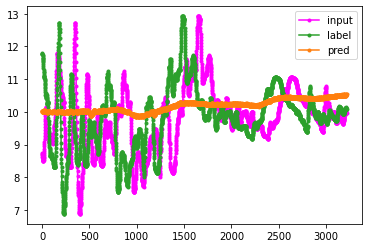

In [43]:
val_nse['Linear'], val_pbias['Linear'], pred, label = compa(
    model=multi_linear_model,df=test_df,
    plot_col=out_features[0], target_std=target_std, target_mean=target_mean, predict_day = rnn_predict_day)

print()
print()

print(val_nse['Linear'])
print(val_pbias['Linear'])
print(pred)
print(label)

In [44]:
val_nse['Linear'], val_pbias['Linear'], pred, label = multi_window.compa(
     multi_linear_model, plot_col=out_features[0], windows=multi_window.example3,
     target_std=target_std, target_mean=target_mean, predict_day = rnn_predict_day)

val_nse['Linear'], val_pbias['Linear']

(0.005532689626282061, 2.789049728856724)

In [34]:
val_nse['Linear'], val_pbias['Linear'], pred, label = multi_window.compa(
     multi_linear_model, plot_col=out_features[0], windows=multi_window.example3,
     target_std=target_std, target_mean=target_mean, predict_day = rnn_predict_day)
val_nse['ELMAN'], val_pbias['ELMAN'], pred, label = multi_window.compa(
     elman_model, plot_col=out_features[0], windows=multi_window.example3,
     target_std=target_std, target_mean=target_mean, predict_day = rnn_predict_day)
val_nse['GRU'], val_pbias['GRU'], pred, label = multi_window.compa(
     gru_model, plot_col=out_features[0], windows=multi_window.example3,
     target_std=target_std, target_mean=target_mean, predict_day = rnn_predict_day)
val_nse['LSTM'], val_pbias['LSTM'], pred, label = multi_window.compa(
     multi_lstm_model, plot_col=out_features[0], windows=multi_window.example3,
     target_std=target_std, target_mean=target_mean, predict_day = rnn_predict_day)
val_nse['CONV'], val_pbias['CONV'], pred, label = multi_window.compa(
     multi_conv_model, plot_col=out_features[0], windows=multi_window.example3,
     target_std=target_std, target_mean=target_mean, predict_day = rnn_predict_day)

In [35]:
print("save model path : ", model_path)
print("year : " + start_year + " ~ "+ end_year)
print('run : ', run_num)
print('tatget : ', rnn_target_column)
print('target col index : ', target_col_idx)
print('Linear : ', val_nse['Linear'], val_pbias['Linear'])
print('ELMAN : ', val_nse['ELMAN'], val_pbias['ELMAN'])
print('GRU : ', val_nse['GRU'], val_pbias['GRU'])
print('LSTM : ', val_nse['LSTM'], val_pbias['LSTM'])
print('CNN : ', val_nse['CONV'], val_pbias['CONV'])
print('GAIN_VAL_PER : ', gain_val_performance)
print('GAIN_TEST_PER : ', gain_performance)

save model path :  save/nak/models/do/
year : 2016 ~ 2019
run :  range(0, 10)
tatget :  do
target col index :  2
Linear :  -0.029002987594253682 3.549402237353611
ELMAN :  -0.14589551911411847 3.781575336817001
GRU :  -0.0674840561382739 2.8642169241077755
LSTM :  -0.2416948437732509 5.087002062874813
CNN :  -0.2833268070301158 5.334029683798345
GAIN_VAL_PER :  {'0': 0.885938286781311, '2': 0.965539276599884, '3': 1.1720067262649536, '4': 0.9280495047569275}
GAIN_TEST_PER :  {'0': 0.9461759328842163, '2': 1.0514578819274902, '3': 0.4141814112663269, '4': 0.9667384028434753}


In [ ]:

x = np.arange(len(val_nse))
width = 0.35
plt.figure()
plt.title(watershed + '  ['+start_year+','+end_year+']  ' + rnn_target_column)
plt.bar(x, val_pbias.values(), 0.3, label='PBIAS' )
plt.bar(x + width, val_nse.values(), 0.3, label='NSE')
plt.xticks(x,val_nse.keys(), rotation=0)
_ = plt.legend()
plt.show()

